# Segmentation and Feature Extraction Berit data
After aligning signals from different devices with tapping cues, signals need to be processed, resampled and output per section/condition. 

### accelerometer data

1. Import timing of concert segments
2. Import accelerometer measurements across devices and resample to rate of 50 Hz
3. Output QoM accross all devices per day, and segment, and role (singer, audience).

### Cardiac data
Before segmenting the cardiac measurements Demonstrate the extraction of relevant features (RR, HR) from each of the cardiac measurements:

1. Movesense EKG
2. Delsys EKG
3. Delsys EMG
4. Delsys mini EMG
5. (Movesense HR?)

With Heart Rate estimate protocals for each of these signals, output the following
    
1. Heart Rate at 5 Hz, in same structure as QoM (participant columns, per day per segment)
2. RR peak timings in folders like files of the rest.


Note: look up PhysAnalysis .m files for feature extraction examples

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json 
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d

import heartpy as hp

# Segments

In [2]:
concert_times = pd.read_csv('Film_meland_hele_events.csv',",") #SV alignment for beeps
concert_times['S_AudioTime'] = 2*np.round(concert_times["TIME"]/2,3) # reset to 50 hz
concert_times['event'] = concert_times["LABEL"]
concert_times['CTime'] = concert_times['S_AudioTime']-concert_times.loc[6,'S_AudioTime'] # zero on onset of first synch cue
key_times = concert_times.loc[[18,19,24,25,26,28,30,31,32,33,34,35],['CTime','event']]
key_times

,CTime,event
18,91.082,Baseline 1 clean start
19,385.156,Baseline 1 end
24,510.274,Song 1 start
25,742.730,Song 1 end
26,745.930,Applause 1 start
28,754.624,Applause 1 end
30,781.610,Song 2 start
31,958.684,Song 2 end
32,961.408,Applause 2 start
33,971.692,Applause 2 end


In [3]:
Segments = {'Baseline1':[91.082,385.156],'Song1':[510.274,742.730],'Song2':[781.610,958.684],'Baseline2':[992.884,1292.884]}

# Accelerometry Segmentation 
First pull up the acc files for all devices, resample, combine, and output segments

In [49]:
d = 'Day2'#'Day1'
path = './'+d+'/Timed/'
file_locs = []
for root, dirs, files in os.walk(path):
    for file in files:
        if file.lower().endswith("acc_stream.csv") or file.lower().endswith("acc_day2.csv"): # ignoring the json files for now, those are only from datalogger
            file_locs.append(os.path.join(root,file))
            
file_locs.sort()
file_locs

['./Day2/Timed/20230111T114001Z_223130000541_acc_stream.csv',
 './Day2/Timed/20230111T114544Z_223130000510_acc_stream.csv',
 './Day2/Timed/20230111T114544Z_223130000551_acc_stream.csv',
 './Day2/Timed/Delsys_acc_Day2.csv']

In [50]:
DelsysIDs = {'D01T':'Trignosensor1',
 'D03T':'Trignosensor3',
 'D04T':'Trignosensor4',
 'D05T':'Trignosensor5',
 'D06M':'TrignoMinisensor6',
 'D07M':'TrignoMinisensor7',
 'D08M':'TrignoMinisensor8',
 'D09M':'TrignoMinisensor9',
 'D11E':'EKGsensor11',
 'D12E':'EKGsensor12',
 'D13E':'EKGsensor13',
 'D14E':'EKGsensor14',
 'ConcertTime': 'Unnamed: 0'}
print(DelsysIDs.keys())
DelsysIDs = dict((v, k) for k, v in DelsysIDs.items())

dict_keys(['D01T', 'D03T', 'D04T', 'D05T', 'D06M', 'D07M', 'D08M', 'D09M', 'D11E', 'D12E', 'D13E', 'D14E', 'ConcertTime'])


In [51]:
sf = 50 # Hz
all_times = np.round(np.arange(0,1300,1/sf),3)
All_ACC = pd.DataFrame(index = all_times)

In [52]:
for file in file_locs: # ./Day1/Timed/20230110T115335Z_223130000596_acc_stream.csv is the singer
#     SensorType
    if file.split('/')[3].startswith('Delsys'):
        sigs_df = pd.read_csv(file) # already in normed jerk
        sigs_df.rename(DelsysIDs,axis=1,inplace=True)
        sensorIDs = ['D01T', 'D03T', 'D04T', 'D05T', 'D06M', 'D07M', 'D08M', 'D09M', 'D11E', 'D12E', 'D13E', 'D14E']# list(sigs_df.columns[1:])
    else: # file is a movesense measure
        df = pd.read_csv(file)
        sensorIDs = ['MS'+file.split('_')[1][-3:]]
        if sensorIDs[0].endswith('596'):
            sensorIDs[0]='Singer'
        X = np.sqrt(np.square(df.loc[:,['x','y','z']].diff()).sum(axis=1))/2 # minor compensation for difference is sample rates
        sigs_df = pd.DataFrame(columns = ['times',sensorIDs[0]])
        sigs_df['ConcertTime'] = df['ConcertTime'].values
        sigs_df[sensorIDs[0]] = X
    
    sensorTime = sigs_df['ConcertTime'].values
    for s in sensorIDs:
        t_range = all_times[(all_times>sensorTime.min()) & (all_times<sensorTime.max())]
        f = interpolate.interp1d(sensorTime, sigs_df[s],fill_value='extrapolate')
        All_ACC.loc[t_range,s] = f(np.array(t_range))

#     SensorID
#     Resample
#     Add to All_ACC
All_ACC.iloc[:5,:]   

,MS541,MS510,MS551,D01T,D03T,D04T,D05T,D06M,D07M,D08M,D09M,D11E,D12E,D13E,D14E
0.00,0.188978,3.021005,0.026542,0.038549,0.194382,0.065778,0.038549,10.589458,0.008940,0.022124,0.008940,0.242808,0.014225,0.057861,0.002975
0.02,0.124407,2.720233,0.067964,0.525052,0.059769,2.929973,4.952774,2.811294,0.009482,0.387712,0.020552,0.083733,0.022073,1.431500,0.003991
0.04,0.084673,1.119941,2.577502,3.863475,0.000000,0.613318,1.994299,0.347891,0.011062,3.710198,4.996662,0.037931,0.014665,0.365909,0.005302
0.06,0.075968,0.956697,46.665516,0.660253,0.038550,0.090147,0.345810,0.090856,0.000000,0.422147,0.377091,0.092249,0.007488,0.103016,0.003161
0.08,0.058846,0.446446,11.892846,0.187158,0.022029,0.054675,0.102787,0.085733,0.006705,0.129266,0.215772,0.170504,0.023979,0.078178,0.003359


In [53]:
# normalise by average per sensor type
sensorIDs = list(All_ACC.columns)
with_s = [x for x in sensorIDs if x.startswith('MS')]
C = All_ACC.loc[:,with_s].mean().mean()
if d == 'Day1':
    with_s.append('Singer')
All_ACC.loc[:,with_s] = All_ACC.loc[:,with_s]/C

sensor_sets = ['T','M','E']
for sensor in sensor_sets:
    with_s = [x for x in sensorIDs if x.endswith(sensor)]
    C = All_ACC.loc[:,with_s].mean().mean()
    All_ACC.loc[:,with_s] = All_ACC.loc[:,with_s]/C
    
All_ACC.mean()

MS541    0.980689
MS510    0.935918
MS551    1.083393
D01T     1.222299
D03T     1.173597
D04T     1.015048
D05T     0.589056
D06M     1.051555
D07M     1.013674
D08M     0.954832
D09M     0.979939
D11E     1.082425
D12E     1.044235
D13E     0.879288
D14E     0.994051
dtype: float64

### segment according to the sections of the concert
Include applause or not?  Since applause complicates the HR measures, no we wont right now. 

In [54]:
sig_type = 'QoM_ACC'
Full_Sig = All_ACC.copy()
Full_Sig.to_csv('./Out_Data/Motion/Full/'+d+'_'+sig_type+'.csv')

for seg in Segments.keys():
    seg_range = Segments[seg]
    Excerpt = Full_Sig.loc[seg_range[0]:seg_range[1],:]
    Excerpt.to_csv('./Out_Data/Motion/Segmented/'+d+'_'+seg+'_'+sig_type+'.csv')

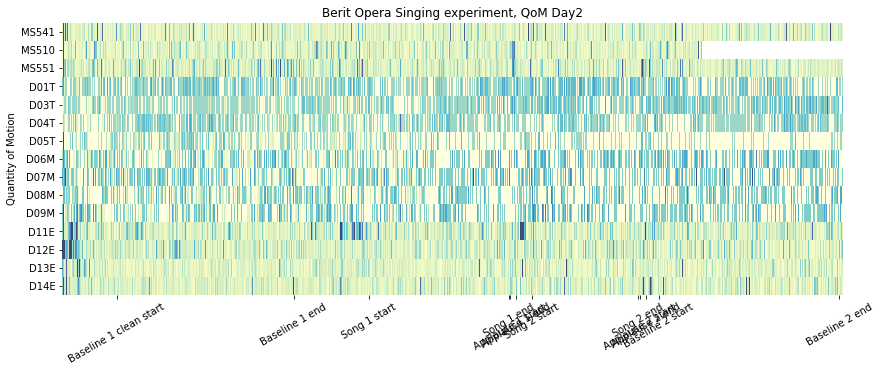

In [55]:
if d == 'Day1':
    FullSig = All_ACC.loc[:,['MS593', 'MS620','D13E', 'D14E', 'D12E', 'D11E', 'D09M','D06M', 'D07M', 'D08M', 'D01T', 'D03T', 'D04T']]
else:
    FullSig = All_ACC
fig, (ax1) = plt.subplots(1, 1,figsize = [14,5])
chart = sns.heatmap(data=FullSig.transpose(), ax=ax1,vmin=0, vmax=4,cbar=False, cmap="YlGnBu",alpha=0.8)
new_xticks = len(FullSig)*(key_times['CTime'])/(All_ACC.index[-1])
ax1.set_xticks(new_xticks)
ax1.set_xticklabels(key_times['event'])
ax1.tick_params(axis='x',grid_color='k',labelrotation=30)


plt.title('Berit Opera Singing experiment, QoM '+ d)
plt.ylabel('Quantity of Motion')
plt.savefig('./Out_Data/Plots/'+d+'_qom.png',dpi = 300)
plt.show()

# Now for the cardiac data, Testing Extraction
Test cardiac data extraction per measurement type

Before segmenting the cardiac measurements Demonstrate the extraction of relevant features (RR, HR) from each of the cardiac measurements:

1. Movesense ECG
2. Delsys EKG
3. Delsys EMG
4. Delsys mini EMG
5. (Movesense HR?)

https://python-heart-rate-analysis-toolkit.readthedocs.io/en/latest/quickstart.html

https://github.com/paulvangentcom/heartrate_analysis_python/blob/master/examples/2_regular_ECG/Analysing_a_regular_ECG_signal.ipynb

https://github.com/paulvangentcom/heartrate_analysis_python/blob/master/examples/1_regular_PPG/Analysing_a_PPG_signal.ipynb


## Movesense ECG first

In [56]:
d = 'Day1'
path = './'+d+'/Timed/'
file_locs = []
for root, dirs, files in os.walk(path):
    for file in files:
        if file.lower().endswith("ecg_stream.csv"): # ignoring the json files for now, those are only from datalogger
            file_locs.append(os.path.join(root,file))
            
file_locs.sort()
file_locs

['./Day1/Timed/20230110T114502Z_223130000593_ecg_stream.csv',
 './Day1/Timed/20230110T114502Z_223130000620_ecg_stream.csv',
 './Day1/Timed/20230110T115335Z_223130000596_ecg_stream.csv']

In [57]:
file = file_locs[2]
print(file)
df = pd.read_csv(file)
sensorID = 'MS'+file.split('_')[1][-3:]
df.iloc[:5,:]
rec_start = df.iloc[0,0]
rec_end = df.iloc[-1,0]
sf = np.round(len(df)/(rec_end-rec_start))
print([rec_start, rec_end, sf, len(df), len(df)/sf,])

./Day1/Timed/20230110T115335Z_223130000596_ecg_stream.csv
[410.902, 1222.644, 500.0, 405872, 811.744]


In [58]:
# correct range sampled to take off times sensor removal and placement
df = df.loc[df['ConcertTime']>0,:].copy()
df = df.loc[df['ConcertTime']<1300,:].copy()
df.reset_index(inplace=True,drop = True)
rec_start = np.round(df.iloc[0,0])
rec_end = df.iloc[-1,0]
sf = np.round(len(df)/(rec_end-rec_start))
print([rec_start, rec_end, sf, len(df), len(df)/sf,])

[411.0, 1222.644, 500.0, 405872, 811.744]


<AxesSubplot:xlabel='ConcertTime'>

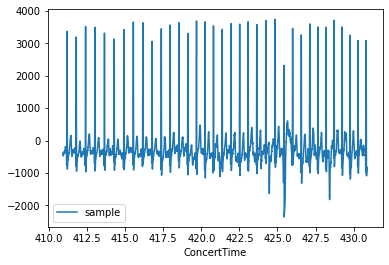

In [59]:
# sample signal 
df.loc[:20*sf].plot(x ='ConcertTime',y='sample')

bpm: 111.845038
ibi: 536.456522
sdnn: 42.010458
sdsd: 5.947076
rmssd: 9.126703
pnn20: 0.032967
pnn50: 0.000000
hr_mad: 22.000000
sd1: 6.369002
sd2: 58.551101
s: 1171.537790
sd1/sd2: 0.108777
breathingrate: 0.133333


/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/heartpy/visualizeutils.py:119: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


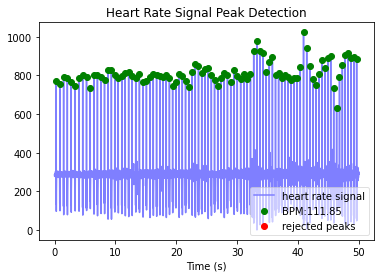

In [60]:
data = df['sample'].values
filtered = hp.filter_signal(data, cutoff = 0.05, sample_rate = sf, filtertype='notch')
#verify signal
wd, m = hp.process(hp.scale_data(filtered[:int(sf*50)]), sf)
hp.plotter(wd, m)
#display computed measures
for measure in m.keys():
    print('%s: %f' %(measure, m[measure]))

In [61]:
working_data, measures = hp.process(filtered, sf, report_time=True)
peak_times = df.iloc[working_data['peaklist'],0].values

sig_type = 'Peak_times'
Full_Sig = pd.DataFrame(index = peak_times,data = peak_times)
Full_Sig.to_csv('./Out_Data/HeartBeats/Full/'+d+'_'+sensorID+'_'+sig_type+'.csv')

for seg in Segments.keys():
    seg_range = Segments[seg]
    Excerpt = Full_Sig.loc[seg_range[0]:seg_range[1],:]
    Excerpt.to_csv('./Out_Data/HeartBeats/Segmented/'+d+'_'+seg+'_'+sensorID+'_'+sig_type+'.csv')


Finished in 0.387112 sec


### get local heart rate


In [62]:
seg_w = 30
seg_o = 0.5
frame = sf*seg_w
hop = sf*seg_w*(1-seg_o)
frames = np.round((len(filtered)-frame)/hop)+1
bpm_time = np.floor(rec_start) + seg_w/2 + np.arange(frames)*(seg_w*(1-seg_o))
bpm_time 

array([ 426.,  441.,  456.,  471.,  486.,  501.,  516.,  531.,  546.,
        561.,  576.,  591.,  606.,  621.,  636.,  651.,  666.,  681.,
        696.,  711.,  726.,  741.,  756.,  771.,  786.,  801.,  816.,
        831.,  846.,  861.,  876.,  891.,  906.,  921.,  936.,  951.,
        966.,  981.,  996., 1011., 1026., 1041., 1056., 1071., 1086.,
       1101., 1116., 1131., 1146., 1161., 1176., 1191., 1206.])

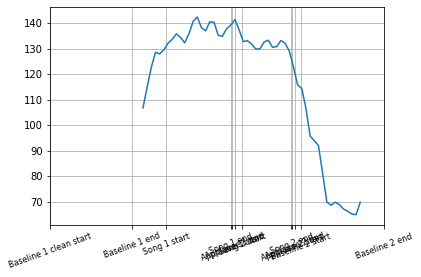

In [63]:
working_data, measures = hp.process_segmentwise(filtered, sample_rate=sf, segment_width = seg_w, segment_overlap = seg_o)
bpm_s = measures['bpm'] # other signal of interest, must estimate sample rate

plt.plot(bpm_time,bpm_s,)
plt.xticks(key_times['CTime'],key_times['event'], rotation='20',fontsize=8)
plt.grid()
plt.show()


It looks like we can use the segment wise heart rate to produce shared sample points across devices. 

Day one, MS sensors perform very well with extractable HR estimate and peaks.
Note that the singer's measures are shorter than the rest.

Day two also looks good and clear, even through clapping.


## Delsys cardiac signals

In [64]:
d = 'Day2'
path = './'+d+'/Timed/'
file_locs = []
for root, dirs, files in os.walk(path):
    for file in files:
        if file.lower().startswith("delsys"): # ignoring the json files for now, those are only from datalogger
            file_locs.append(os.path.join(root,file))
            
file_locs.sort()
file_locs

['./Day2/Timed/Delsys_acc_Day2.csv',
 './Day2/Timed/Delsys_ekg_Day2.csv',
 './Day2/Timed/Delsys_emg_Day2.csv']

In [65]:
file = file_locs[1]
print(file)
df = pd.read_csv(file)
df.rename(DelsysIDs,axis=1,inplace=True)
# df.rename(columns={"Unnamed: 0": 'ConcertTime'},inplace=True)
sensorID = df.columns[1:]
print(sensorID)
df.iloc[:5,:]
rec_start = df.iloc[0,0]
rec_end = df.iloc[-1,0]
sf = np.round(len(df)/(rec_end-rec_start))
print([rec_start, rec_end, sf, len(df), len(df)/sf,])


./Day2/Timed/Delsys_ekg_Day2.csv
Index(['D11E', 'D13E', 'D14E', 'D12E'], dtype='object')
[-389.02, 1337.25, 1259.0, 2173824, 1726.6274821286736]


In [66]:
# correct range sampled to take off times sensor removal and placement
df = df.loc[df['ConcertTime']>15,:].copy() 
# 15 s after sync need to remove the trace of tapping form EKG
df = df.loc[df['ConcertTime']<1300,:].copy()
df.reset_index(inplace=True,drop = True)
rec_start = np.round(df.iloc[0,0])
rec_end = df.iloc[-1,0]
sf = np.round(len(df)/(rec_end-rec_start))
print([rec_start, rec_end, sf, len(df), len(df)/sf,])

[15.0, 1299.99, 1259.0, 1618141, 1285.2589356632247]


<AxesSubplot:xlabel='ConcertTime'>

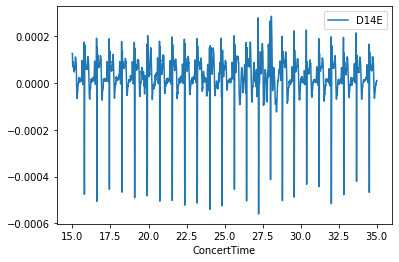

In [67]:
sN = sensorID[2]
# sample signal 
df.loc[:20*sf].plot(x ='ConcertTime',y=sN)

bpm: 69.467112
ibi: 863.718072
sdnn: 47.415408
sdsd: 8.016177
rmssd: 12.131607
pnn20: 0.107143
pnn50: 0.000000
hr_mad: 43.685465
sd1: 8.524138
sd2: 66.712524
s: 1786.519399
sd1/sd2: 0.127774
breathingrate: 0.266667


/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/heartpy/visualizeutils.py:119: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


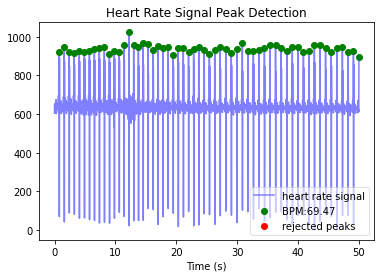

In [68]:
data = df[sN].values
filtered = hp.filter_signal(data, cutoff = 0.05, sample_rate = sf, filtertype='notch')
#verify signal
wd, m = hp.process(hp.scale_data(filtered[:int(sf*50)]), sf)
hp.plotter(wd, m)
#display computed measures
for measure in m.keys():
    print('%s: %f' %(measure, m[measure]))

In [69]:
working_data, measures = hp.process(filtered, sf, report_time=True)
peak_times = df.iloc[working_data['peaklist'],0].values
len(peak_times)


Finished in 0.963971 sec


1444

In [70]:
seg_w = 30
seg_o = 0.5
frame = sf*seg_w
hop = sf*seg_w*(1-seg_o)
frames = np.round((len(filtered)-frame)/hop)+1
bpm_time = np.floor(rec_start) + seg_w/2 + np.arange(frames)*(seg_w*(1-seg_o))
bpm_time 

array([  30.,   45.,   60.,   75.,   90.,  105.,  120.,  135.,  150.,
        165.,  180.,  195.,  210.,  225.,  240.,  255.,  270.,  285.,
        300.,  315.,  330.,  345.,  360.,  375.,  390.,  405.,  420.,
        435.,  450.,  465.,  480.,  495.,  510.,  525.,  540.,  555.,
        570.,  585.,  600.,  615.,  630.,  645.,  660.,  675.,  690.,
        705.,  720.,  735.,  750.,  765.,  780.,  795.,  810.,  825.,
        840.,  855.,  870.,  885.,  900.,  915.,  930.,  945.,  960.,
        975.,  990., 1005., 1020., 1035., 1050., 1065., 1080., 1095.,
       1110., 1125., 1140., 1155., 1170., 1185., 1200., 1215., 1230.,
       1245., 1260., 1275., 1290.])

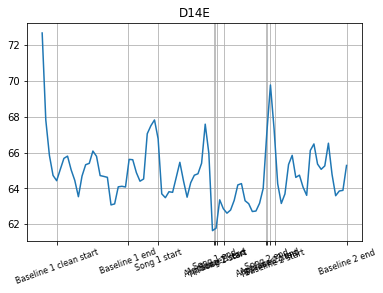

In [71]:
working_data, measures = hp.process_segmentwise(filtered, sample_rate=sf, segment_width = seg_w, segment_overlap = seg_o)
bpm_s = measures['bpm'] # other signal of interest, must estimate sample rate

plt.plot(bpm_time,bpm_s,)
plt.xticks(key_times['CTime'],key_times['event'], rotation='20',fontsize=8)
plt.title(sN)
plt.grid()
plt.show()

 The Delsys EKG recordings are pretty good 
 
 Day 1
 D13E good
 D14E good 
 D12E also very clear
 D11E good
 
 Day 2 
 D11E all good 
 D13E also good
 D14D also good, with filtering
 D12E is also good 
 
 Starting after the sync cue takes care of all funny business

## Delsys EMG signals (for cardiac)

In [72]:
file = file_locs[2]
print(file)
df = pd.read_csv(file)
df.rename(DelsysIDs,axis=1,inplace=True)
# df.rename(columns={"Unnamed: 0": 'ConcertTime'},inplace=True)
sensorID = df.columns[1:]
print(sensorID)
df.iloc[:5,:]
rec_start = df.iloc[0,0]
rec_end = df.iloc[-1,0]
sf = np.round(len(df)/(rec_end-rec_start))
print([rec_start, rec_end, sf, len(df), len(df)/sf,])


./Day2/Timed/Delsys_emg_Day2.csv
Index(['D08M', 'D07M', 'D06M', 'D09M', 'D01T', 'D05T', 'D03T', 'D04T'], dtype='object')
[-389.02, 1337.25, 1926.0, 3324672, 1726.2056074766356]


In [73]:
# correct range sampled to take off times sensor removal and placement
df = df.loc[df['ConcertTime']>15,:].copy() 
# 15 s after sync need to remove the trace of tapping form EKG
df = df.loc[df['ConcertTime']<1300,:].copy()
df.reset_index(inplace=True,drop = True)
rec_start = np.round(df.iloc[0,0])
rec_end = df.iloc[-1,0]
sf = np.round(len(df)/(rec_end-rec_start))
print([rec_start, rec_end, sf, len(df), len(df)/sf,])

[15.0, 1299.99, 1926.0, 2474804, 1284.944963655244]


<AxesSubplot:xlabel='ConcertTime'>

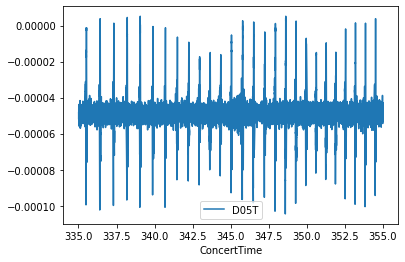

In [74]:
sN = sensorID[5]
# sample signal 
df.loc[320*sf:340*sf].plot(x ='ConcertTime',y=sN)

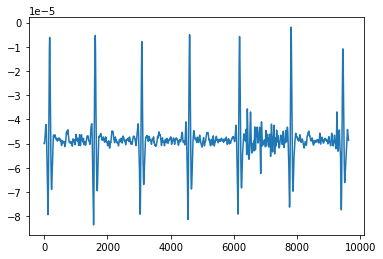

In [75]:
data = df[sN].values
filtered = hp.filter_signal(data, cutoff = [30], sample_rate = sf,order = 1, filtertype='lowpass')
#(data, cutoff = [0.5, 3.5], sample_rate = sf,order = 3, filtertype='bandpass')
plt.plot(filtered[int(15*sf):int(20*sf)])
#(data, cutoff = 0.05, sample_rate = sf, filtertype='notch')
#verify signal

Filterning for the EMG recording of cardiac activity is quite different from the ECG and EKG recordings. These are also a lot more sensitive to noise. 

bpm: 70.100850
ibi: 855.909731
sdnn: 66.882821
sdsd: 19.299383
rmssd: 29.424151
pnn20: 0.425926
pnn50: 0.092593
hr_mad: 47.767394
sd1: 20.804057
sd2: 93.866827
s: 6134.936167
sd1/sd2: 0.221634
breathingrate: 0.133333


/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/heartpy/visualizeutils.py:119: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


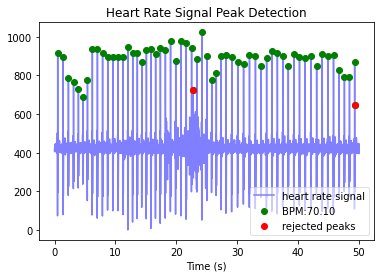

In [76]:
wd, m = hp.process(hp.scale_data(filtered[:int(sf*50)]), sf)
hp.plotter(wd, m)
#display computed measures
for measure in m.keys():
    print('%s: %f' %(measure, m[measure]))

In [77]:
key_times

,CTime,event
18,91.082,Baseline 1 clean start
19,385.156,Baseline 1 end
24,510.274,Song 1 start
25,742.730,Song 1 end
26,745.930,Applause 1 start
28,754.624,Applause 1 end
30,781.610,Song 2 start
31,958.684,Song 2 end
32,961.408,Applause 2 start
33,971.692,Applause 2 end


In [78]:
working_data, measures = hp.process(filtered, sf, report_time=True)
peak_times = df.iloc[working_data['peaklist'],0].values
len(peak_times)


Finished in 1.929673 sec


1415

In [79]:
seg_w = 30
seg_o = 0.5
frame = sf*seg_w
hop = sf*seg_w*(1-seg_o)
frames = np.round((len(filtered)-frame)/hop)+1
bpm_time = np.floor(rec_start) + seg_w/2 + np.arange(frames)*(seg_w*(1-seg_o))
bpm_time 

array([  30.,   45.,   60.,   75.,   90.,  105.,  120.,  135.,  150.,
        165.,  180.,  195.,  210.,  225.,  240.,  255.,  270.,  285.,
        300.,  315.,  330.,  345.,  360.,  375.,  390.,  405.,  420.,
        435.,  450.,  465.,  480.,  495.,  510.,  525.,  540.,  555.,
        570.,  585.,  600.,  615.,  630.,  645.,  660.,  675.,  690.,
        705.,  720.,  735.,  750.,  765.,  780.,  795.,  810.,  825.,
        840.,  855.,  870.,  885.,  900.,  915.,  930.,  945.,  960.,
        975.,  990., 1005., 1020., 1035., 1050., 1065., 1080., 1095.,
       1110., 1125., 1140., 1155., 1170., 1185., 1200., 1215., 1230.,
       1245., 1260., 1275., 1290.])

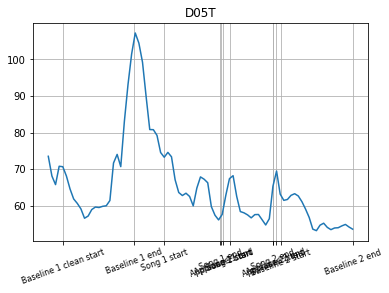

In [80]:
working_data, measures = hp.process_segmentwise(filtered, sample_rate=sf, segment_width = seg_w, segment_overlap = seg_o)
bpm_s = measures['bpm'] # other signal of interest, must estimate sample rate

plt.plot(bpm_time,bpm_s,)
plt.xticks(key_times['CTime'],key_times['event'], rotation='20',fontsize=8)
plt.title(sN)
plt.grid()
plt.show()

Day 1

EMG 0, D09M, has messy begining and applause but seens to be readable through baselines and most of songs.

EMG 1, D06M, applause again a problem but other wise OK

EMG 2, D07M, has a lot of interference making precision sampling very unreliably. Applayse really messes it up, as does a varity of other things. 

EMG 3, D08M, looks OK save applause

EMG 4 D01T has interferences in baseline 1 as well and end of songs

EMG 5 D03T begining way off, and applause 2

EMG 6, D04T is beautiful and clear

EMG 7, D05T is empty

Day 2

EMG 0, D08M is clear throughout 

EMG 1, D07M has a stray peak at the begining of the baseline 1

EMG 2, D06M has a jump at end of baseline 2

EMG 3, D08M has stray peaks around the applause 

EMG 4, D01T is clear

EMG 5, D05T looks clear 

EMG 6, D03T looks clear

EMG 7, D04T has a surprise peak in Stim 1, otherwise looks fine.


# Aggregating heart data for output
With heartpy, we can rapidly extract beat peaks across the different sensors and export the data into a shared format.

for the three formates of recordings, the data need to be prepared differently, but they can be sampled for roughly synchronous local measures of rate (30 s, 15 s step). But need to repress noise based peaks that pop up in EMG data. 

First is to extract the heart rates for full performance at this sampling across devices for each day. Then save per segment of experiment.

In [101]:
d = 'Day2'
path = './'+d+'/Timed/'

In [102]:
rec_start = 15.0 # seconds after the sync cue, to avoid interference from that contact
rec_end =1300.0 # seconds, after the second baseline but before the devices were removed for all but the singer
# this is the sampling terms of the 
seg_w = 30
seg_o = 0.5
frame = sf*seg_w
hop = sf*seg_w*(1-seg_o)
frames = np.round((len(filtered)-frame)/hop)+1
bpm_time = np.floor(rec_start) + seg_w/2 + np.arange(frames)*(seg_w*(1-seg_o))

bpm_day = pd.DataFrame(index = bpm_time)

first the MS files

In [103]:
file_locs = []
for root, dirs, files in os.walk(path):
    for file in files:
        if file.lower().endswith("ecg_stream.csv"): # ignoring the json files for now, those are only from datalogger
            file_locs.append(os.path.join(root,file))
            
file_locs.sort()
file_locs

['./Day2/Timed/20230111T114001Z_223130000541_ecg_stream.csv',
 './Day2/Timed/20230111T114544Z_223130000510_ecg_stream.csv',
 './Day2/Timed/20230111T114544Z_223130000551_ecg_stream.csv']

In [104]:
for file in file_locs:
    rec_start = 15.0 # seconds after the sync cue, to avoid interference from that contact
    rec_end =1300.0 # seconds, after the second baseline but before the devices were removed for all but the singer
    sN = 'sample'
    df = pd.read_csv(file)
    sensorID = 'MS'+file.split('_')[1][-3:]
    df = df.loc[df['ConcertTime']>rec_start,:].copy() 
    df = df.loc[df['ConcertTime']<rec_end,:].copy()
    df.reset_index(inplace=True,drop = True)
    b_time = bpm_time
    if file.endswith('596_ecg_stream.csv'):
        # this is the singers data
        sensorID = 'Singer'
        rec_start = df.iloc[0,0]
        rec_end = df.iloc[-1,0]
    sf = np.round(len(df)/(rec_end-rec_start))
    print([sensorID, sf, len(df), len(df)/sf,])
    
    data = df[sN].values
    filtered = hp.filter_signal(data, cutoff = 0.05, sample_rate = sf, filtertype='notch')
    working_data, measures = hp.process(filtered, sf, report_time=True)
    peak_times = df.iloc[working_data['peaklist'],0].values
    sig_type = 'Peak_times'
    Full_Sig = pd.DataFrame(index = peak_times,data = peak_times)
    Full_Sig.to_csv('./Out_Data/HeartBeats/Full/'+d+'_'+sensorID+'_'+sig_type+'.csv')
    for seg in Segments.keys():
        seg_range = Segments[seg]
        Excerpt = Full_Sig.loc[seg_range[0]:seg_range[1],:]
        Excerpt.to_csv('./Out_Data/HeartBeats/Segmented/'+d+'_'+seg+'_'+sensorID+'_'+sig_type+'.csv')
   
    working_data, measures = hp.process_segmentwise(filtered, sample_rate=sf, segment_width = seg_w, segment_overlap = seg_o)
    bpm_s = measures['bpm']
    if sensorID == 'Singer':
        bpm_day.loc[seg_w/2 + rec_start:rec_end,sensorID] = measures['bpm']
    else:
        bpm_day.loc[rec_start:rec_end,sensorID] = measures['bpm']
bpm_day

['MS541', 512.0, 657673, 1284.517578125]

Finished in 0.604161 sec


/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/scipy/interpolate/fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


['MS510', 418.0, 537147, 1285.0406698564593]

Finished in 0.503189 sec
['MS551', 512.0, 657920, 1285.0]

Finished in 0.605225 sec


,MS541,MS510,MS551
30.0,64.753598,58.461538,52.703398
45.0,64.173804,57.758444,52.972824
60.0,64.537815,57.826087,53.838065
75.0,64.467912,56.444111,54.538750
90.0,63.118964,53.117587,54.257184
...,...,...,...
1230.0,63.159570,51.432966,56.582304
1245.0,63.781394,49.606066,54.423549
1260.0,63.567389,46.753120,54.564831
1275.0,62.224023,46.617100,53.443961


In [105]:
file_locs=[]
for root, dirs, files in os.walk(path):
    for file in files:
        if file.lower().startswith("delsys"): # ignoring the json files for now, those are only from datalogger
            file_locs.append(os.path.join(root,file))
            
file_locs.sort()
file_locs

['./Day2/Timed/Delsys_acc_Day2.csv',
 './Day2/Timed/Delsys_ekg_Day2.csv',
 './Day2/Timed/Delsys_emg_Day2.csv']

In [106]:
# EKG next
file = file_locs[1]
print(file)
df = pd.read_csv(file)
df.rename(DelsysIDs,axis=1,inplace=True)
sensorIDs = df.columns[1:]
print(sensorIDs)

rec_start = 15.0 # seconds after the sync cue, to avoid interference from that contact
rec_end =1300.0 # seconds, after the second baseline but before the devices were removed for all but the singer
df = df.loc[df['ConcertTime']>rec_start,:].copy() 
df = df.loc[df['ConcertTime']<rec_end,:].copy()
df.reset_index(inplace=True,drop = True)
sf = np.round(len(df)/(rec_end-rec_start))
print([rec_start, rec_end, sf, len(df), len(df)/sf,])


./Day2/Timed/Delsys_ekg_Day2.csv
Index(['D11E', 'D13E', 'D14E', 'D12E'], dtype='object')
[15.0, 1300.0, 1259.0, 1618141, 1285.2589356632247]


In [107]:
for sensorID in sensorIDs:
    data = df[sensorID].values
    filtered = hp.filter_signal(data, cutoff = 0.05, sample_rate = sf, filtertype='notch')
    working_data, measures = hp.process(filtered, sf, report_time=True)
    peak_times = df.iloc[working_data['peaklist'],0].values
    sig_type = 'Peak_times'
    Full_Sig = pd.DataFrame(index = peak_times,data = peak_times)
    Full_Sig.to_csv('./Out_Data/HeartBeats/Full/'+d+'_'+sensorID+'_'+sig_type+'.csv')
    for seg in Segments.keys():
        seg_range = Segments[seg]
        Excerpt = Full_Sig.loc[seg_range[0]:seg_range[1],:]
        Excerpt.to_csv('./Out_Data/HeartBeats/Segmented/'+d+'_'+seg+'_'+sensorID+'_'+sig_type+'.csv')

    working_data, measures = hp.process_segmentwise(filtered, sample_rate=sf, segment_width = seg_w, segment_overlap = seg_o)
    bpm_s = measures['bpm']
    bpm_day.loc[rec_start:rec_end,sensorID] = measures['bpm']
bpm_day


Finished in 1.257857 sec

Finished in 1.149774 sec

Finished in 0.981308 sec

Finished in 1.046952 sec


,MS541,MS510,MS551,D11E,D13E,D14E,D12E
30.0,64.753598,58.461538,52.703398,79.666306,78.822866,72.694029,54.229782
45.0,64.173804,57.758444,52.972824,73.869723,77.410064,67.827961,54.503677
60.0,64.537815,57.826087,53.838065,71.432624,65.098966,65.849502,55.570834
75.0,64.467912,56.444111,54.538750,71.216162,62.210388,64.728228,57.761757
90.0,63.118964,53.117587,54.257184,67.069165,61.223828,64.433072,57.036830
...,...,...,...,...,...,...,...
1230.0,63.159570,51.432966,56.582304,61.151137,63.396502,64.785592,56.203808
1245.0,63.781394,49.606066,54.423549,62.939510,63.215096,63.593242,57.003638
1260.0,63.567389,46.753120,54.564831,61.078619,62.517587,63.856468,60.086929
1275.0,62.224023,46.617100,53.443961,59.954080,61.710471,63.892413,63.301676


In [108]:
# EMG next
file = file_locs[2]
print(file)
df = pd.read_csv(file)
df.rename(DelsysIDs,axis=1,inplace=True)
if d == 'Day1':
    sensorIDs = df.columns[1:-1] # if day 1
else: 
    sensorIDs = df.columns[1:]
print(sensorIDs)

rec_start = 15.0 # seconds after the sync cue, to avoid interference from that contact
rec_end =1300.0 # seconds, after the second baseline but before the devices were removed for all but the singer
df = df.loc[df['ConcertTime']>rec_start,:].copy() 
df = df.loc[df['ConcertTime']<rec_end,:].copy()
df.reset_index(inplace=True,drop = True)
sf = np.round(len(df)/(rec_end-rec_start))
print([rec_start, rec_end, sf, len(df), len(df)/sf,])

./Day2/Timed/Delsys_emg_Day2.csv
Index(['D08M', 'D07M', 'D06M', 'D09M', 'D01T', 'D05T', 'D03T', 'D04T'], dtype='object')
[15.0, 1300.0, 1926.0, 2474804, 1284.944963655244]


In [109]:
for sensorID in sensorIDs:
    data = df[sensorID].values
    filtered = hp.filter_signal(data, cutoff = [30], sample_rate = sf,order = 1, filtertype='lowpass')
    working_data, measures = hp.process(filtered, sf, report_time=True)
    # output peak_times somehow
    peak_times = df.iloc[working_data['peaklist'],0].values
    sig_type = 'Peak_times'
    Full_Sig = pd.DataFrame(index = peak_times,data = peak_times)
    Full_Sig.to_csv('./Out_Data/HeartBeats/Full/'+d+'_'+sensorID+'_'+sig_type+'.csv')
    for seg in Segments.keys():
        seg_range = Segments[seg]
        Excerpt = Full_Sig.loc[seg_range[0]:seg_range[1],:]
        Excerpt.to_csv('./Out_Data/HeartBeats/Segmented/'+d+'_'+seg+'_'+sensorID+'_'+sig_type+'.csv')
    #Estimate Heart Rate in 30 s segments, overlapping by 15 s
    working_data, measures = hp.process_segmentwise(filtered, sample_rate=sf, segment_width = seg_w, segment_overlap = seg_o)
    bpm_s = measures['bpm']
    v = pd.Series(index = bpm_time, data = measures['bpm'])
    v[v>1.25*v.median()]=np.nan # remove noise driven leaps in heart rate estimate
    bpm_day.loc[:,sensorID] = v
bpm_day


Finished in 2.114368 sec

Finished in 1.972035 sec

Finished in 1.921305 sec

Finished in 1.700882 sec


/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/numpy/ma/core.py:5240: RuntimeWarning: Mean of empty slice.
  result = super(MaskedArray, self).mean(axis=axis,
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



Finished in 1.719153 sec

Finished in 2.598133 sec

Finished in 1.829262 sec

Finished in 1.856998 sec


,MS541,MS510,MS551,D11E,D13E,D14E,D12E,D08M,D07M,D06M,D09M,D01T,D05T,D03T,D04T
30.0,64.753598,58.461538,52.703398,79.666306,78.822866,72.694029,54.229782,68.140445,54.105345,53.107594,65.969291,69.176893,73.523831,77.038533,73.250507
45.0,64.173804,57.758444,52.972824,73.869723,77.410064,67.827961,54.503677,67.581343,53.487619,52.355926,66.205180,66.665734,68.128272,74.144255,57.691402
60.0,64.537815,57.826087,53.838065,71.432624,65.098966,65.849502,55.570834,67.874840,53.027886,54.116715,70.681781,67.296310,65.784487,72.231449,57.479260
75.0,64.467912,56.444111,54.538750,71.216162,62.210388,64.728228,57.761757,67.769899,53.465347,54.299604,68.645997,67.242245,70.799892,72.028209,57.677005
90.0,63.118964,53.117587,54.257184,67.069165,61.223828,64.433072,57.036830,64.834401,53.565096,52.357933,65.129452,67.082449,70.677628,71.474518,57.505253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230.0,63.159570,51.432966,56.582304,61.151137,63.396502,64.785592,56.203808,75.123340,54.485710,54.236872,72.598073,66.182013,54.000971,74.806876,63.138340
1245.0,63.781394,49.606066,54.423549,62.939510,63.215096,63.593242,57.003638,76.911122,56.274146,55.429384,75.468811,69.274468,54.499547,74.378889,60.906167
1260.0,63.567389,46.753120,54.564831,61.078619,62.517587,63.856468,60.086929,77.472213,56.639861,54.078727,75.879490,68.310106,54.903658,74.308475,59.799789
1275.0,62.224023,46.617100,53.443961,59.954080,61.710471,63.892413,63.301676,75.045546,54.458058,55.358614,73.091695,66.212824,54.197738,75.433471,61.230329


In [110]:
bpm_day.std()

MS541    0.910997
MS510    3.211704
MS551    1.221300
D11E     5.367360
D13E     3.378382
D14E     1.690923
D12E     2.035279
D08M     3.377707
D07M     0.922590
D06M     1.670910
D09M     3.281468
D01T     1.500180
D05T     6.062732
D03T     1.953839
D04T     3.041128
dtype: float64

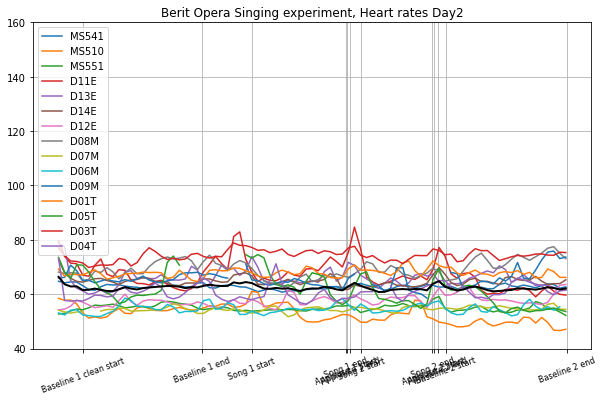

In [111]:
bpm_day.plot(figsize=[10,6])
if d == 'Day1':
    bpm_day.loc[:,['MS593', 'MS620','D13E', 'D14E', 'D12E', 'D11E', 'D09M','D06M', 'D07M', 'D08M', 'D01T', 'D03T', 'D04T']].mean(axis=1).plot(color='k',linewidth=2,label='Mean')
else:
    bpm_day.mean(axis=1).plot(color='k',linewidth=2,label='Mean')
plt.xticks(key_times['CTime'],key_times['event'], rotation='20',fontsize=8)
plt.title('Berit Opera Singing experiment, Heart rates '+ d)
plt.ylim([40,160])
plt.grid()
plt.savefig('./Out_Data/Plots/'+d+'_bpm.png',dpi = 300)
plt.show()

In [112]:
sig_type = 'HR_BPM'
Full_Sig = bpm_day.copy()
Full_Sig.to_csv('./Out_Data/HR/Full/'+d+'_'+sig_type+'.csv')

for seg in Segments.keys():
    seg_range = Segments[seg]
    Excerpt = Full_Sig.loc[seg_range[0]:seg_range[1],:]
    Excerpt.to_csv('./Out_Data/HR/Segmented/'+d+'_'+seg+'_'+sig_type+'.csv')

In [ ]:
bpm_day.to_csv(path+d+'_bmp_30s.csv')